# 주식 예측하기

# 삼성전자

In [1]:
# 주요 라이브러리 버전 확인
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.3
1.0
0.13.0


데이터셋 다운로드 방법  
[Yahoo Finance](https://finance.yahoo.com/)에서 samsung 검색 후 Historical Data에서 Download

## Step 1. 시계열 데이터 준비

In [2]:
# 필요한 모듈 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/samsung.csv'
df = pd.read_csv(dataset_filepath)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
1,2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2,2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
3,2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
4,2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


- 컬럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있지만 종가(Close)만 사용

In [4]:
# Time Series(시계열) 생성하기
df = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates=True)
ts=df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## Step 2. 각종 전처리 수행

In [6]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]
# Time Series에서 결측치가 있는 부분만 Series로 출력하기
# 처음 확인했을 때 결측치가 없었지만 혹시 몰라 결측치 보간을 해준 후 다시 결측치 확인

Series([], Name: Close, dtype: float64)

[결측치 보간](https://rfriend.tistory.com/264)  
결측치 보간이란 예를 들어 2와 4 사이 데이터가 NaN이라면 이 값을 3으로 채우는 방식이다.  
결측치가 있을 때 결측치를 보간을 하는 방법 외에도 결측치가 있는 데이터를 모두 삭제(drop)하는 방법도 있다.

In [7]:
# 로그 변환
ts_log = np.log(ts)

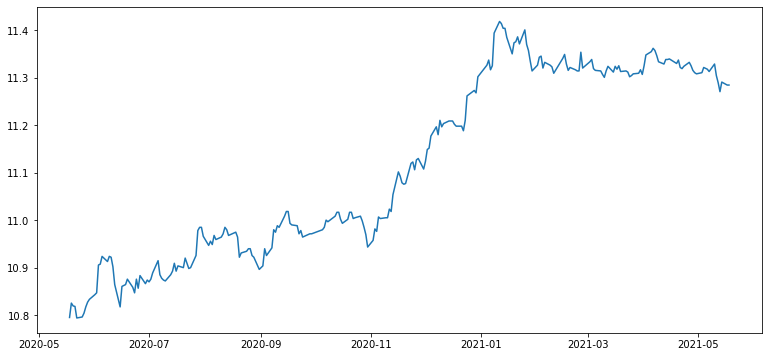

In [8]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 

plt.plot(ts_log)

## Step 3. 시계열 안정성 분석

### 정성적 그래프 분석

In [9]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean() # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std() # 이동표준편차 시계열
    
    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화 해보기
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

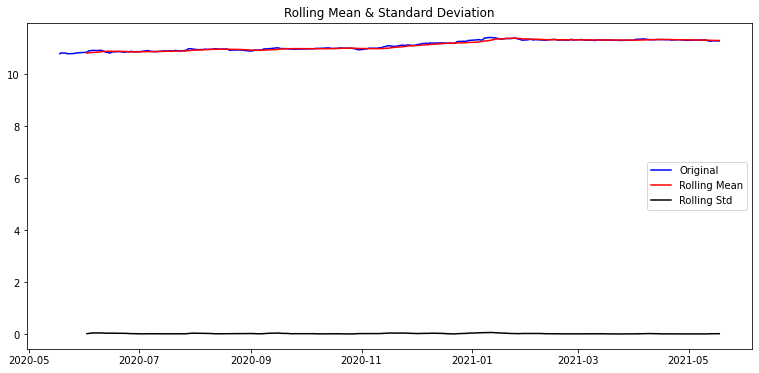

In [12]:
# 로그 변환 후
plot_rolling_statistics(ts_log, window=12)

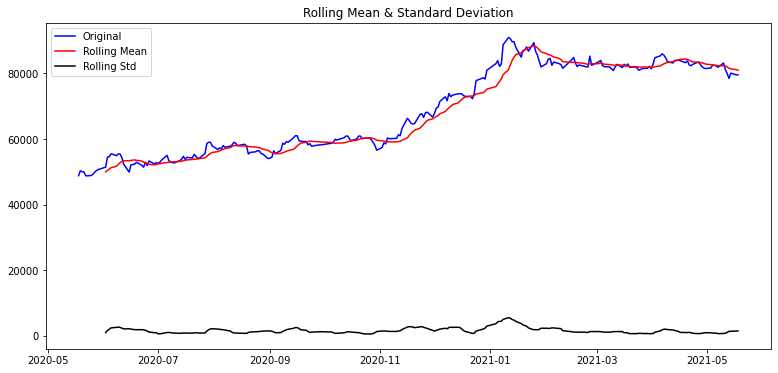

In [13]:
# 로그 변환 전
plot_rolling_statistics(ts, window=12)

로그 변환을 하면 큰 수를 같은 비율의 작은 수로 변환을 해주어 각종 왜곡을 줄일 수 있다는 장점을 가지고 있다. 하지만 plot으로 시각화했을 때 작은 수로 이루어져 눈으로 stationary한지 어떤지 파악하기가 굉장히 힘들었다.  
그래서 로그 변환하기 전 그래프도 그려봤고 이 경우에는 눈으로만 봐도 원본과 평균의 차이가 심해 stationary하지 않다고 느꼈다.

### 정량적 Augmented Dicky-Fuller Test

In [14]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC') 
    
    #adfuller 메서드가 리턴한 결과를 정리하여 출력하기
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

[adfuller](https://hongl.tistory.com/98) : ADF Test를 쉽게 할 수 있는 메서드  
autolag='AIC' : autolag는 ADF Test에서 p를 자동으로 지정하는데 그 중 AIC가 가장 낮게 나오는 p를 자동으로 설정하고 autolag를 지정하면 maxlag에서 지정한 값 무시된다.
[AIC](https://student9725.tistory.com/28) : 두 확률분포 사이의 차이를 표현한 것

In [15]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


정량적 테스트를 했을 때 정성적 그래프에서 나의 생각과는 전혀 다른 결과가 나왔다. p-value가 0.05미만인 경우 귀무가설이 기각되고 stationary하다고 볼 수 있는데, 삼성전자 주식 데이터의 경우 p-value=0.59로 stationary 하다고 볼 수 없다.

### 시계열 분해(Time Series Decomposition)

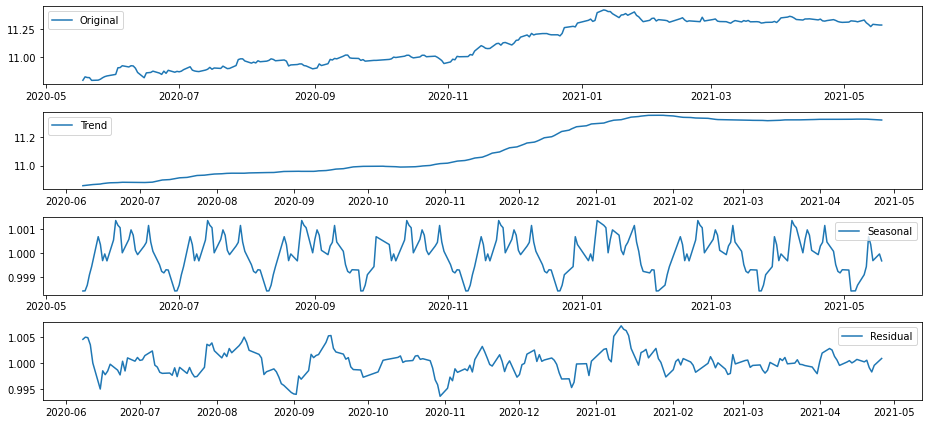

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
# residual = (로그변환한)원본 - trend - seasonal

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()

[plt.legend()](https://codetorial.net/matplotlib/set_legend.html)  
legend() 함수의 loc 파라미터를 이용해 범례가 표시될 위치 설정 가능하다. best는 그래프의 최적의 위치에 표시한다는 의미이다.

### Residual 안정성 확인

In [17]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


trend와 seasonal을 제거해 준 residual의 stationary를 확인했을 때 p-value=6.234653e-08<0.05로 stationary하다.

## Step 4. 학습, 테스트 데이터셋 생성

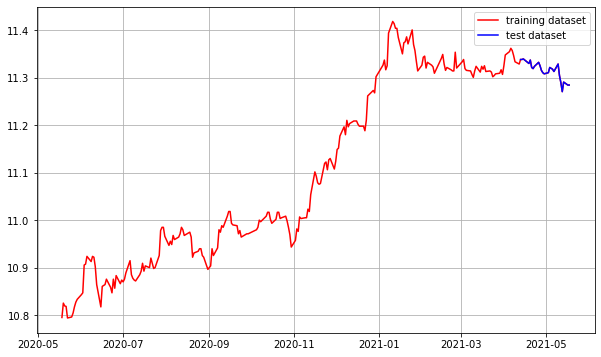

In [18]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
# 학습데이터 : 테스트데이터 = 9 : 1 (학습데이터는 앞쪽부터 시작해서 9, 테스트데이터는 뒤쪽 1)
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset') # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## Step 5. 적정 ARIMA 모수 찾기

### ACF, PACF를 그려본 후 p,q 구하기

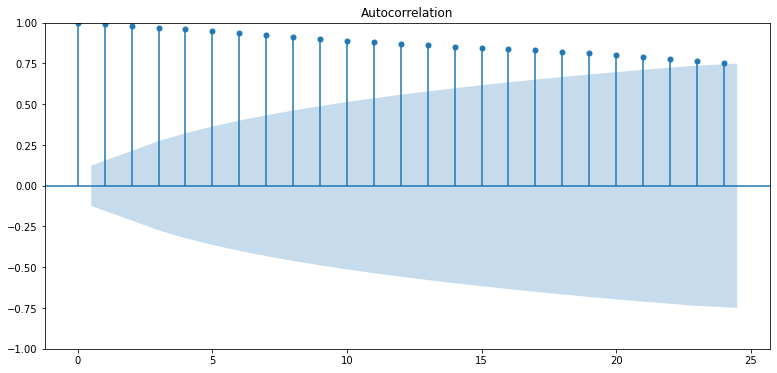

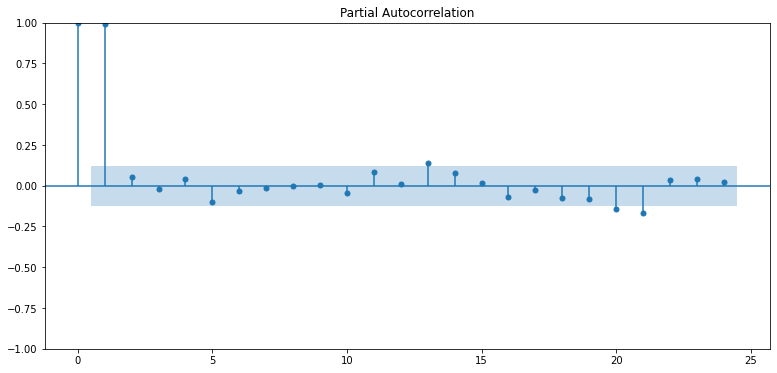

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log) 
plot_pacf(ts_log)
plt.show()

[p,d,q 값(모수)을 구하는 방법](https://velog.io/@sjina0722/%EC%8B%9C%EA%B3%84%EC%97%B4%EB%B6%84%EC%84%9D-ARIMA-%EB%AA%A8%EB%8D%B8)  

- 일반적으로 AR과 MA 중 하나만 고려되는 경우가 많으므로 보통 p,q 값 중 하나는 0이 된다.
  1. AR모델을 선택하는 경우 : ACF가 완만하게 떨어지는 그래프(non stationary) -> q=0 / PACF는 lag p 이후에 확 떨어지는(절단) 그래프  
  2. MA모델을 선택하는 경우 : PACF가 완만하게 떨어지는 그래프(non stationary) -> p=0 / ACF는 lag q 이후에 절단되는 패턴  
  3. ARMA모델은 선택하는 경우 : ACF와 PACF가 (q-p)시점 이후부터 떨어질 때  

- d=differencing 했을 때 p-value가 0.05미만이 되는 차분 횟수  

내가 파악한 p,d,q 모수를 구하는 방법이고 이 방법을 바탕으로 봤을 때 ACF가 완만하게 떨어지는 그래프이기 때문에 AR모델을 선택해야하고, q = 0이 된다. PACF는 lag 1이후에 확 떨어지는 그래프 모양을 가지고 있기 때문에 p = 1이 될 것이다.  
모수를 찾는 방법 중에는 auto.arima도 있고, 그 외에도 다양한 방법이 있다고 한다. 아리마에 대해 더 깊게 공부하기에는 아직 부족한 것이 많아 잠시 미뤄두지만 좀 더 실력을 쌓아 이 부분을 더 깊게 공부해야겠다.

### 차분 안정성 확인 후 d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


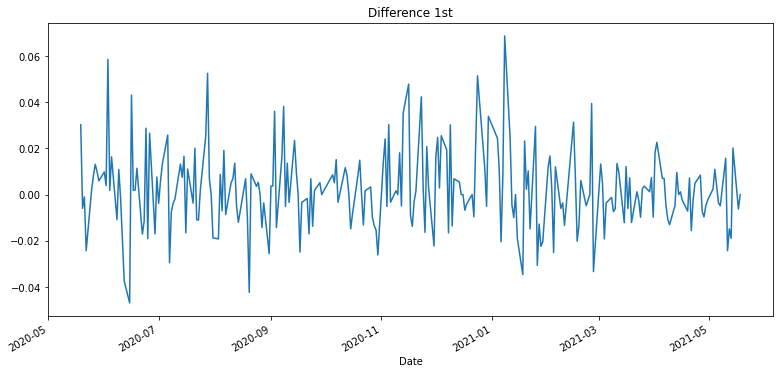

In [20]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

 iloc[1:] : 0은 자기자신이므로 고려하는 의미가 없고 lag 1부터 봐야한다.  
 1차 차분시 p-value=2.183738e-28<0.05이므로 stationary하다. 따라서 d=1이다. 

## Step 6. ARIMA 모델 훈련과 테스트

### ARIMA 모델 빌드와 훈련

In [21]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0)) # 모수 p,d,q 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 583.488
Date:                Sun, 13 Nov 2022   AIC                          -1162.976
Time:                        04:28:42   BIC                          -1156.153
Sample:                             0   HQIC                         -1160.222
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0333      0.061      0.545      0.586      -0.086       0.153
sigma2         0.0003   2.42e-05     13.219      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


### 모델 테스트 및 플로팅

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


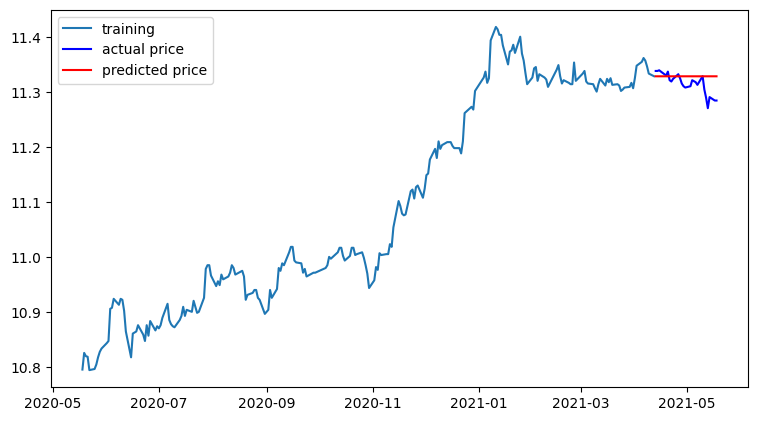

In [22]:
# Forecast : 결과가 fc에 담깁니다. 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  
fc = np.array(fc)

# pandas series로 만들기
fc_series = pd.Series(fc, index=test_data.index)

# Plot 시각화
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

플로팅했을 때 시각적으로 실제 가격과 예측 가격이 잘 맞는 거 같아 보이지는 않는다. 

### 최종 예측 모델 정확도 측정(MAPE)

In [23]:
# 시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차 계산 가능 
# np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)


mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3480513.747715865
MAE:  1403.033723618997
RMSE:  1865.6135043775453
MAPE: 1.74%


MAPE가 0에 가까울수록 회귀 모형의 성능이 좋다고 해석할 수 있다.  
여기서는 MAPE=1.74%로 회귀 모형의 성능이 괜찮은 편인 거 같다.  
[np.abs](https://rfriend.tistory.com/303) : 절댓값을 구하는 함수  
[MAPE](https://acdongpgm.tistory.com/102)

삼성전자 주식을 예측한 과정을 바탕으로 네이버, 카카오와 구글의 주식을 예측해보았다.

-------------

# 네이버

## Step 1. 시계열 데이터 준비
- 컬럼 종류 : Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 각 컬럼이 있지만 Close만 사용하여 주가를 예측하기

In [1]:
# 필요한 모듈 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset_filepath_naver = os.getenv('HOME')+'/aiffel/stock_prediction/data/naver.csv'
df = pd.read_csv(dataset_filepath_naver)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-11-11,411000.0,413000.0,405000.0,407000.0,404606.18750,566739
1,2021-11-12,407500.0,412500.0,403500.0,409000.0,406594.43750,412100
2,2021-11-15,409000.0,412500.0,408000.0,411000.0,408582.68750,331770
3,2021-11-16,410000.0,412500.0,405000.0,405500.0,403115.03125,490783
4,2021-11-17,406000.0,406500.0,399000.0,401000.0,398641.46875,540444


- 컬럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있지만 종가(Close)만 사용

In [4]:
# Time Series(시계열) 생성하기
df = pd.read_csv(dataset_filepath_naver, index_col = 'Date', parse_dates=True)
ts_naver=df['Close']

ts_naver.head()

Date
2021-11-11    407000.0
2021-11-12    409000.0
2021-11-15    411000.0
2021-11-16    405500.0
2021-11-17    401000.0
Name: Close, dtype: float64

## Step 2. 각종 전처리 수행

In [5]:
# 결측치 처리
ts_naver=ts_naver.interpolate(method='time')
ts_naver[ts_naver.isna()]
# Time Series에서 결측치가 있는 부분만 Series로 출력하기
# 혹시 몰라 결측치 보간을 해준 후 결측치 확인

Series([], Name: Close, dtype: float64)

In [9]:
# 로그 변환
ts_naver_log = np.log(ts_naver)

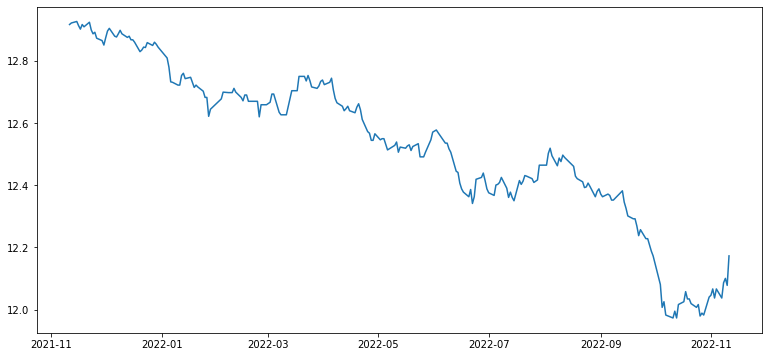

In [10]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 

plt.plot(ts_naver_log)

## Step 3. 시계열 안정성 분석

### 정성적 그래프 분석

In [11]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean() # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std() # 이동표준편차 시계열
    
    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화 해보기
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

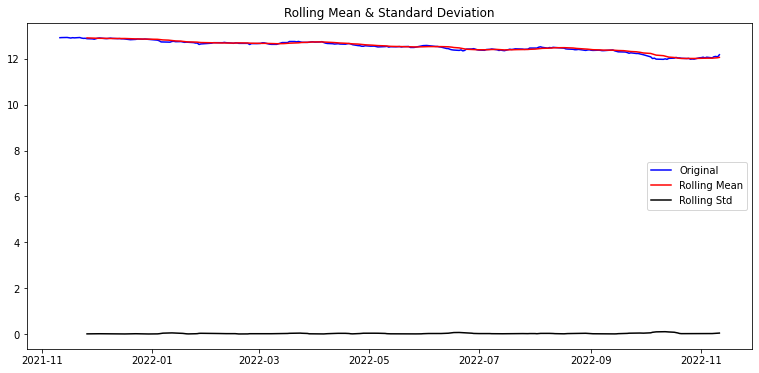

In [14]:
plot_rolling_statistics(ts_naver_log, window=12)

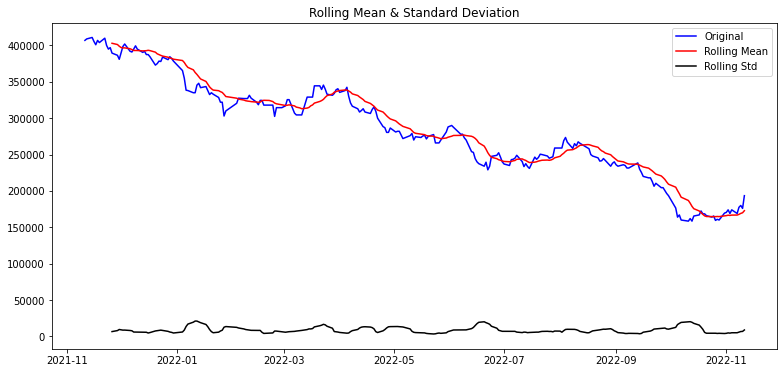

In [15]:
plot_rolling_statistics(ts_naver, window=12)

로그 변환 전 그래프를 바탕으로 보았을 떄 눈으로만 봐도 stationary하지 않다고 느껴진다.

### 정량적 Augmented Dicky-Fuller Test

In [16]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC') 
    
    #adfuller 메서드가 리턴한 결과를 정리하여 출력하기
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [17]:
augmented_dickey_fuller_test(ts_naver_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.858860
p-value                          0.801219
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


ADF test의 p-value=0.801219 > 0.05로 stationary하지 않다.

### 시계열 분해(Time Series Decomposition)

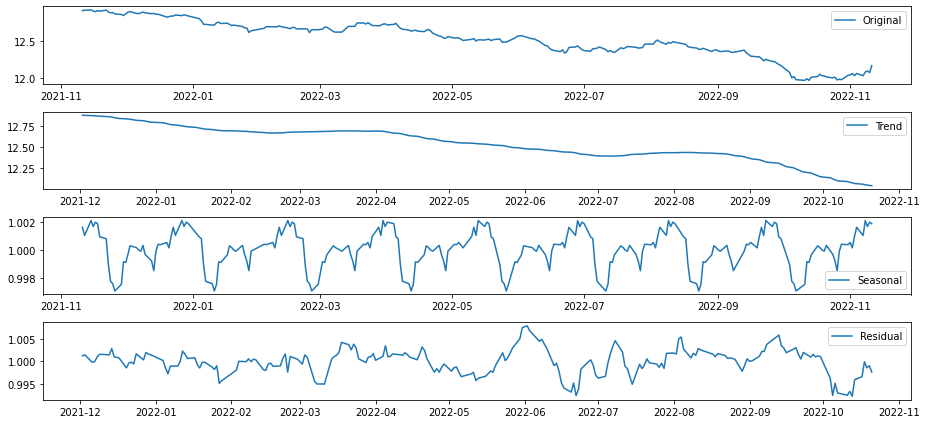

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_naver_log, model='multiplicative', period = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
# residual = (로그변환한)원본 - trend - seasonal

plt.subplot(411)
plt.plot(ts_naver_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()

### Residual 안정성 확인

In [20]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.196668
p-value                          0.000009
#Lags Used                       3.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


trend와 seasonal을 제거해 준 후 residual의 stationary를 확인했을 때 p-value = 0.000009 < 0.05이므로 stationary해졌다는 것을 알 수 있다. 

## Step 4. 학습, 테스트 데이터셋 생성

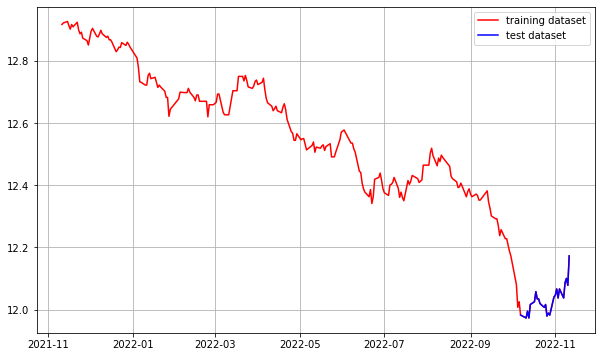

In [22]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_naver_log[:int(len(ts_naver_log)*0.9)], ts_naver_log[int(len(ts_naver_log)*0.9):]
# 학습데이터 : 테스트데이터 = 9 : 1 (학습데이터는 앞쪽부터 시작해서 9, 테스트데이터는 뒤쪽 1)
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_naver_log, c='r', label='training dataset') # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## Step 5. 적정 ARIMA 모수 찾기

### ACF, PACF를 그려본 후 p,q 구하기

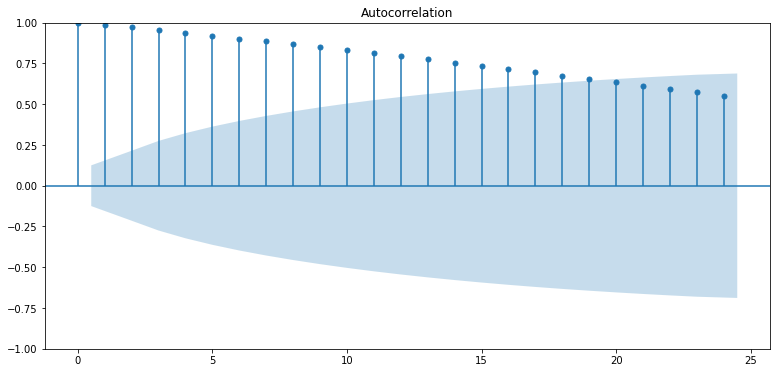

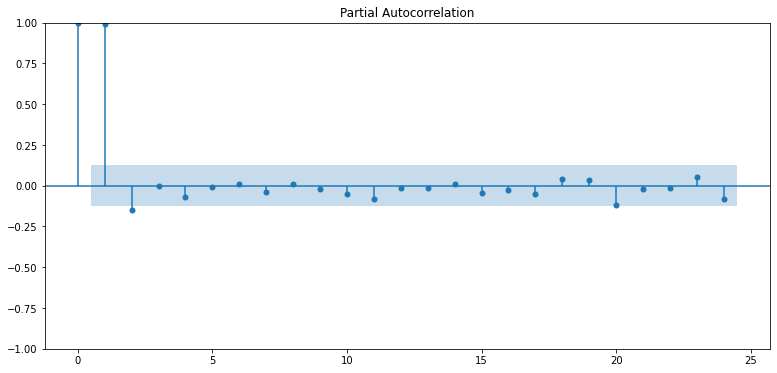

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_naver_log) 
plot_pacf(ts_naver_log)
plt.show()

위에서 파악한 p,q모수값 찾는 방법을 대입해보면 ACF가 완만하게 떨어지고 있으므로 non stationary하고 AR모델을 선택해서 q = 0이다. PACF는 lag 1이후에 확 떨어지는 그래프 모양을 가지고 있기 때문에 p = 1이 될 것이다.  

### 차분 안정성 확인 후 d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -7.328588e+00
p-value                        1.143604e-10
#Lags Used                     3.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


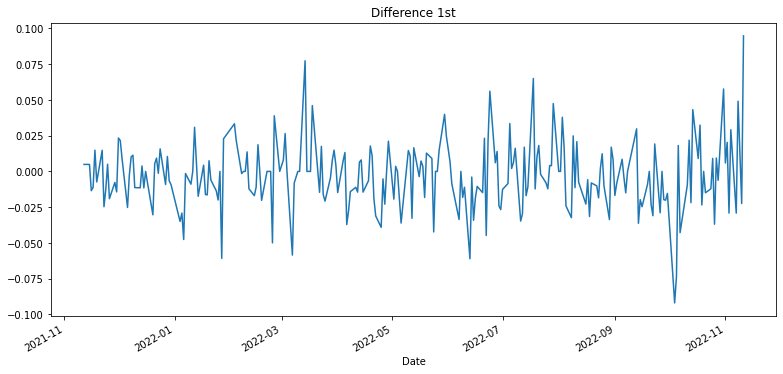

In [24]:
diff_1 = ts_naver_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차 차분 이후에 p-value = 1.143604e-10 < 0.05 로 stationary하기 때문에 d = 1이 된다. 

## Step 6. ARIMA 모델 훈련과 테스트

### ARIMA 모델 빌드와 훈련

In [25]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0)) # 모수 p,d,q 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 524.036
Date:                Sun, 13 Nov 2022   AIC                          -1044.072
Time:                        04:37:43   BIC                          -1037.285
Sample:                             0   HQIC                         -1041.332
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1185      0.059      1.992      0.046       0.002       0.235
sigma2         0.0005   3.59e-05     13.907      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.14   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


### 모델 테스트 및 플로팅

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


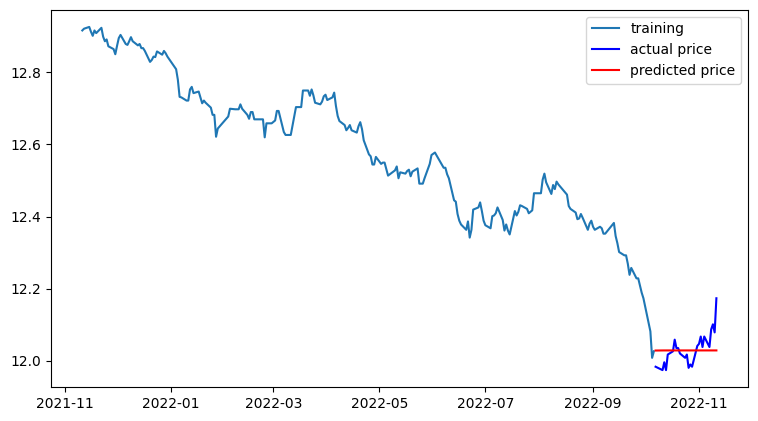

In [26]:
# Forecast : 결과가 fc에 담깁니다. 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  
fc = np.array(fc)

# pandas series로 만들기
fc_series = pd.Series(fc, index=test_data.index)

# Plot 시각화
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 최종 예측 모델 정확도 측정(MAPE)

In [27]:
# 시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차 계산 가능 
# np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)


mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  62832435.889853895
MAE:  5901.51489784742
RMSE:  7926.691358306686
MAPE: 3.44%


MAPE=3.44%가 나왔다.  
혹시나 하는 마음에 MAPE 값을 더 낮출 수 있을 거 같아서 p=2로 다시 정확도를 측정해봤는데 MAPE 값 동일했다. 처음 생각한 p=1이 최적의 파라미터라는 결론을 내렸다.

------------

# 카카오

## Step 1. 시계열 데이터 준비
- 컬럼 종류 : Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 각 컬럼이 있지만 Close만 사용하여 주가를 예측하기

In [1]:
# 필요한 모듈 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_filepath_kakao = os.getenv('HOME')+'/aiffel/stock_prediction/data/kakao.csv'
df = pd.read_csv(dataset_filepath_kakao)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-11-12,126926.562500,128941.273438,125415.531250,127933.914063,127874.609375,2085325
1,2021-11-15,127933.914063,130452.304688,127933.914063,129948.625000,129888.390625,1701656
2,2021-11-16,129948.625000,130955.976563,127933.914063,128437.593750,128378.054688,1579772
3,2021-11-17,128941.273438,129948.625000,125919.210938,125919.210938,125860.843750,1663424
4,2021-11-18,125919.210938,126926.562500,123904.500000,125415.531250,125357.398438,1532653


- 컬럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있지만 종가(Close)만 사용

In [3]:
# Time Series(시계열) 생성하기
df = pd.read_csv(dataset_filepath_kakao, index_col = 'Date', parse_dates=True)
ts_k=df['Close']

ts_k.head()

Date
2021-11-12    127933.914063
2021-11-15    129948.625000
2021-11-16    128437.593750
2021-11-17    125919.210938
2021-11-18    125415.531250
Name: Close, dtype: float64

## Step 2. 각종 전처리 수행

In [4]:
# 결측치 처리
ts_k=ts_k.interpolate(method='time')
ts_k[ts_k.isna()]
# Time Series에서 결측치가 있는 부분만 Series로 출력하기
# 혹시 몰라 결측치 보간을 해준 후 결측치 확인

Series([], Name: Close, dtype: float64)

In [6]:
# 로그 변환
ts_k_log = np.log(ts_k)

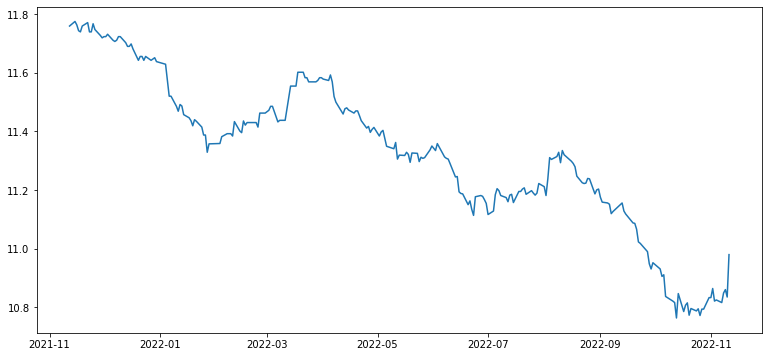

In [7]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 

plt.plot(ts_k_log)

## Step 3. 시계열 안정성 분석

### 정성적 그래프 분석

In [8]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean() # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std() # 이동표준편차 시계열
    
    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화 해보기
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

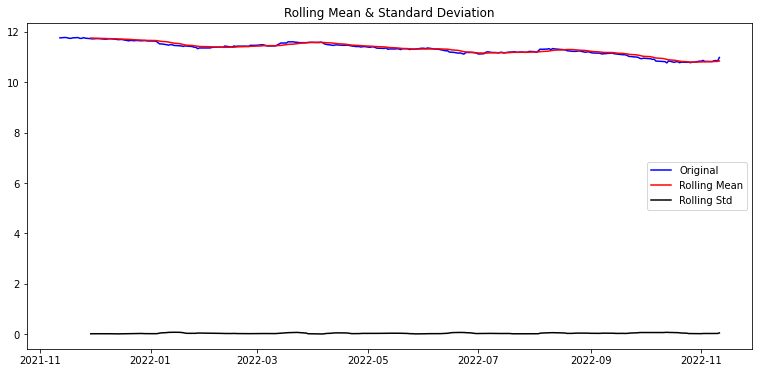

In [9]:
plot_rolling_statistics(ts_k_log, window=12)

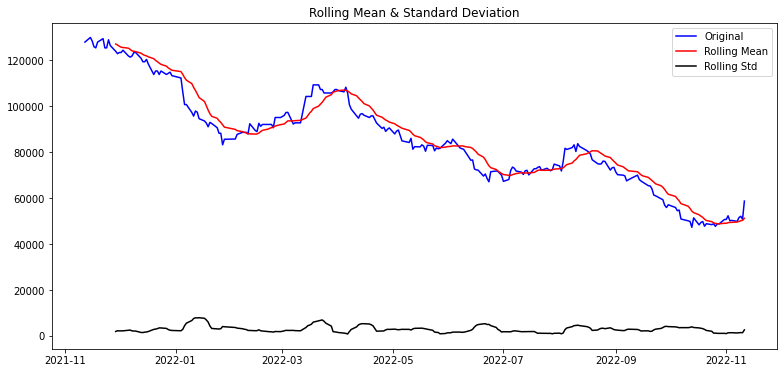

In [10]:
plot_rolling_statistics(ts_k, window=12)

로그 변환 전 시계열을 plot한 결과 stationary한 것은 아니라고 느껴졌다. ADF test를 했을 때 p-value가 다소 높을 것이라고 예상했다. 

### 정량적 Augmented Dicky-Fuller Test

In [11]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC') 
    
    #adfuller 메서드가 리턴한 결과를 정리하여 출력하기
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [12]:
augmented_dickey_fuller_test(ts_k_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.198151
p-value                          0.674390
#Lags Used                       3.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


정량적 평가를 봤을 때 p-value=0.67 >0.05이므로 카카오 주식 데이터셋 역시 stationary하지 않다는 것을 알 수 있다.  
정성적 평가로는 plot으로 시각화를 하더라도 stationary한지 정확하게 평가가 어렵다는 것을 느꼈다.

### 시계열 분해(Time Series Decomposition)

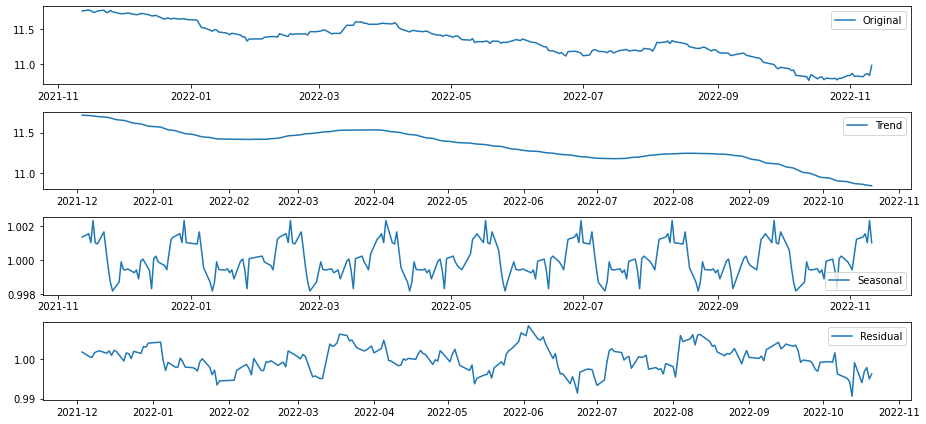

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_k_log, model='multiplicative', period = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
# residual = (로그변환한)원본 - trend - seasonal

plt.subplot(411)
plt.plot(ts_k_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()

### Residual 안정성 확인

In [14]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -3.937562
p-value                          0.001775
#Lags Used                       4.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


trend와 seasonal을 제거한 후의 residual의 stationary를 확인했을 때 p-value=0.0017 < 0.05로 stationary하다는 것을 알 수 있다.

## Step 4. 학습, 테스트 데이터셋 생성

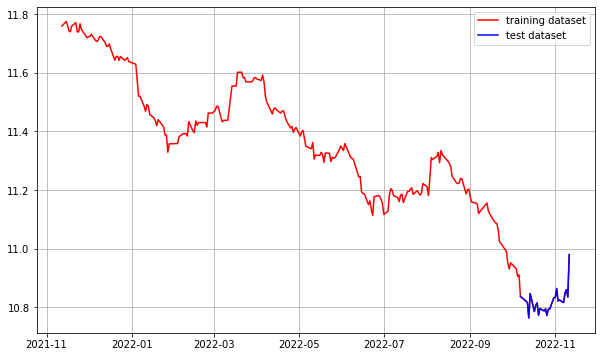

In [15]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_k_log[:int(len(ts_k_log)*0.9)], ts_k_log[int(len(ts_k_log)*0.9):]
# 학습데이터 : 테스트데이터 = 9 : 1 (학습데이터는 앞쪽부터 시작해서 9, 테스트데이터는 뒤쪽 1)
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_k_log, c='r', label='training dataset') # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## Step 5. 적정 ARIMA 모수 찾기

### ACF, PACF를 그려본 후 p,q 구하기

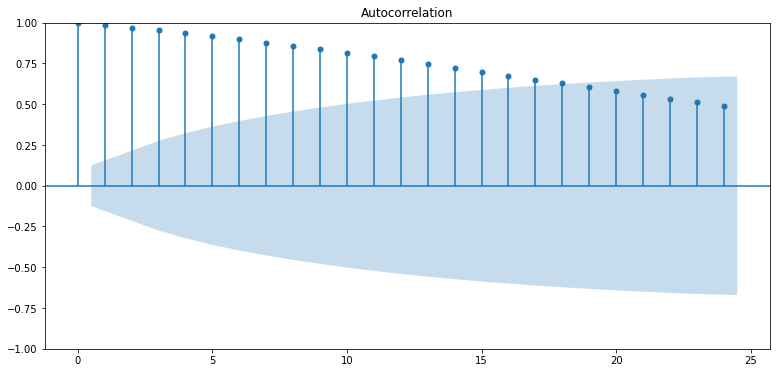

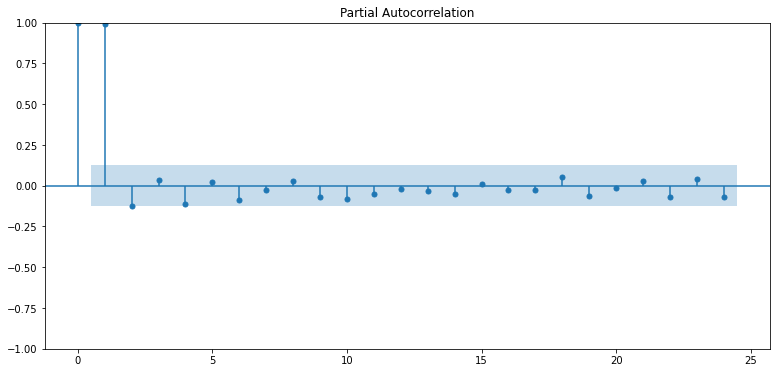

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_k_log) 
plot_pacf(ts_k_log)
plt.show()

위에서 파악한 p,q모수값 찾는 방법을 대입해보면 ACF가 완만하게 떨어지고 있으므로 non stationary하고 AR모델을 선택해서 q = 0이다. PACF는 lag 1이후에 확 떨어지는 그래프 모양을 가지고 있기 때문에 p = 1이 될 것이다.

### 차분 안정성 확인 후 d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -7.065123e+00
p-value                        5.104070e-10
#Lags Used                     2.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


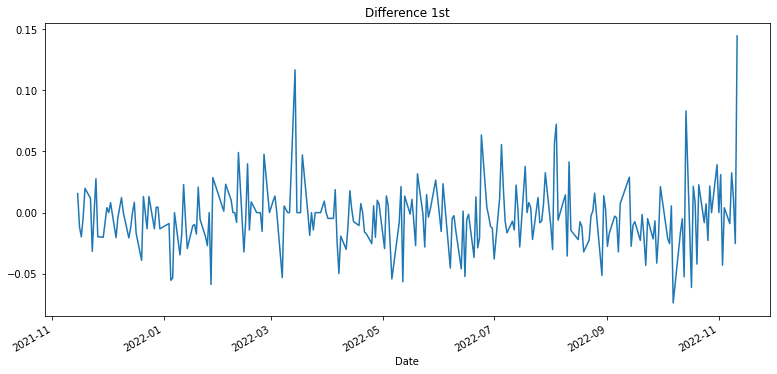

In [17]:
diff_1 = ts_k_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차 차분 이후에 p-value = 5.104070e-10 < 0.05 로 stationary하기 때문에 d = 1이 된다.

## Step 6. ARIMA 모델 훈련과 테스트

### ARIMA 모델 빌드와 훈련

In [18]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0)) # 모수 p,d,q 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  220
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 507.067
Date:                Sun, 13 Nov 2022   AIC                          -1010.135
Time:                        04:49:47   BIC                          -1003.357
Sample:                             0   HQIC                         -1007.397
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0018      0.073      0.025      0.980      -0.142       0.146
sigma2         0.0006   3.62e-05     15.778      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.17   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


### 모델 테스트 및 플로팅

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


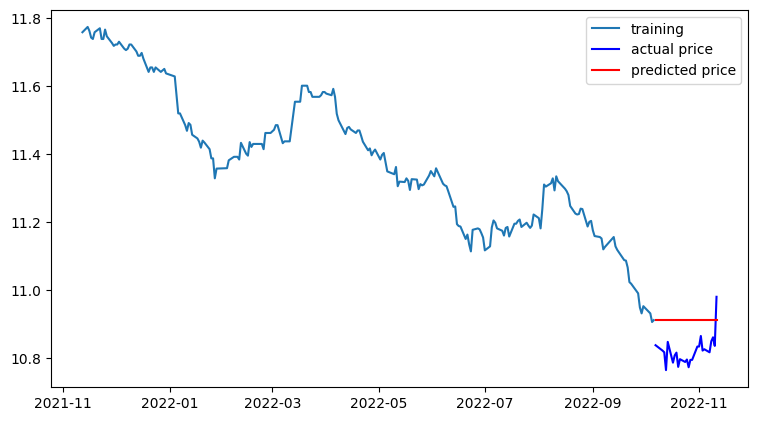

In [19]:
# Forecast : 결과가 fc에 담깁니다. 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  
fc = np.array(fc)

# pandas series로 만들기
fc_series = pd.Series(fc, index=test_data.index)

# Plot 시각화
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 최종 예측 모델 정확도 측정(MAPE)

In [20]:
# 시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차 계산 가능 
# np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)


mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  26665987.972121067
MAE:  4984.510762203484
RMSE:  5163.912080208286
MAPE: 10.05%


MAPE=10.05%로 생각보다 높은 값이 나왔다. 모수를 잘못 찾은 거 같아서 p에 다른 값을 넣어보았다. 

In [30]:
model = ARIMA(train_data, order=(3, 1, 0)) # 모수 p,d,q 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  220
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 513.099
Date:                Sun, 13 Nov 2022   AIC                          -1018.198
Time:                        04:54:35   BIC                          -1004.642
Sample:                             0   HQIC                         -1012.723
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0150      0.072      0.210      0.834      -0.125       0.155
ar.L2         -0.0573      0.079     -0.727      0.467      -0.212       0.097
ar.L3          0.2260      0.073      3.081      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


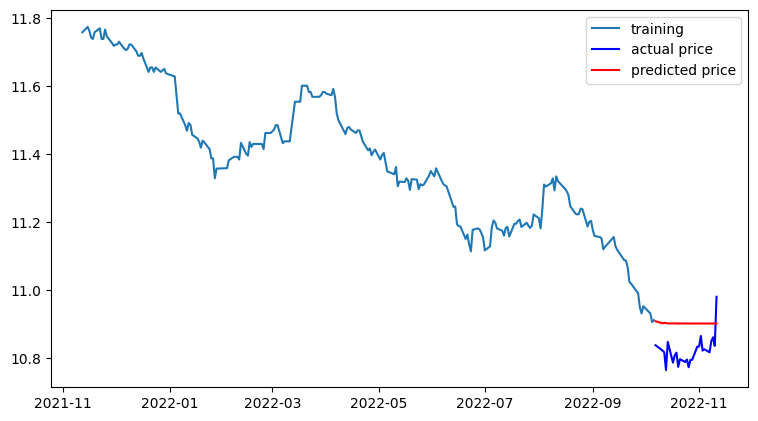

In [31]:
# Forecast : 결과가 fc에 담깁니다. 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  
fc = np.array(fc)

# pandas series로 만들기
fc_series = pd.Series(fc, index=test_data.index)

# Plot 시각화
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [32]:
# 시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차 계산 가능 
# np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)


mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22128406.09956522
MAE:  4512.857382715098
RMSE:  4704.083980921814
MAPE: 9.09%


p=2일 때, MAPE=10.16%  
p=3일 때, MAPE=9.09%  
p=4일 때, MAPE=9.20%  
p=3일 때 그나마 작은 MAPE 값이 나왔다. p에 더 큰 수를 넣었을 때 MAPE값이 더 작아질 수도 있지만 정확하게 어떤 값을 넣어야할 지 몰라 4까지만 넣어보았다. 내가 이해한 방법으로 ACF와 PACF를 바탕으로 p,q값을 찾아냈는데 내가 방법을 잘못 이해한 것인지 원래 어느정도 p값을 주고 거기서 +, -를 해주면서 최적의 값을 찾아나가야 하는건지 잘 모르겠다. 

--------------------

# 구글

## Step 1. 시계열 데이터 준비
- 컬럼 종류 : Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 각 컬럼이 있지만 Close만 사용하여 주가를 예측하기

In [1]:
# 필요한 모듈 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_filepath_goog = os.getenv('HOME')+'/aiffel/stock_prediction/data/GOOG.csv'
df = pd.read_csv(dataset_filepath_goog)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-11-11,147.106995,148.502243,146.694504,146.748001,146.748001,12464000
1,2021-11-12,147.831497,149.859497,146.453995,149.645493,149.645493,17048000
2,2021-11-15,150.000000,150.477005,148.652496,149.388000,149.388000,16248000
3,2021-11-16,149.170502,149.832504,148.350006,149.076004,149.076004,17254000
4,2021-11-17,149.229004,149.626007,148.563004,149.061996,149.061996,15290000


- 컬럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있지만 종가(Close)만 사용

In [3]:
# Time Series(시계열) 생성하기
df = pd.read_csv(dataset_filepath_goog, index_col = 'Date', parse_dates=True)
ts_g=df['Close']

ts_g.head()

Date
2021-11-11    146.748001
2021-11-12    149.645493
2021-11-15    149.388000
2021-11-16    149.076004
2021-11-17    149.061996
Name: Close, dtype: float64

## Step 2. 각종 전처리 수행

In [4]:
# 결측치 처리
ts_g=ts_g.interpolate(method='time')
ts_g[ts_g.isna()]
# Time Series에서 결측치가 있는 부분만 Series로 출력하기
# 혹시 몰라 결측치 보간을 해준 후 결측치 확인

Series([], Name: Close, dtype: float64)

In [5]:
# 로그 변환
ts_g_log = np.log(ts_g)

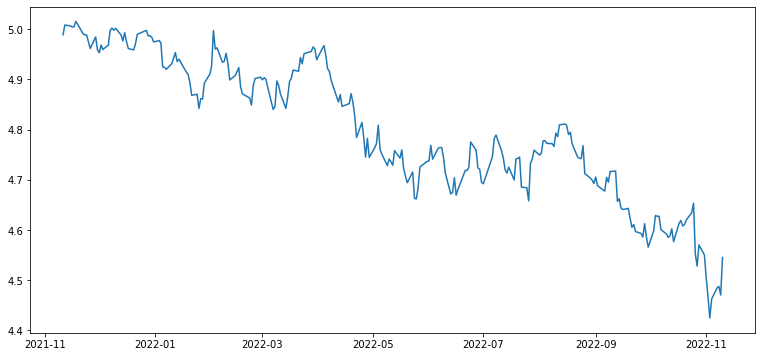

In [6]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 

plt.plot(ts_g_log)

## Step 3. 시계열 안정성 분석

### 정성적 그래프 분석

In [7]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean() # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std() # 이동표준편차 시계열
    
    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화 해보기
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

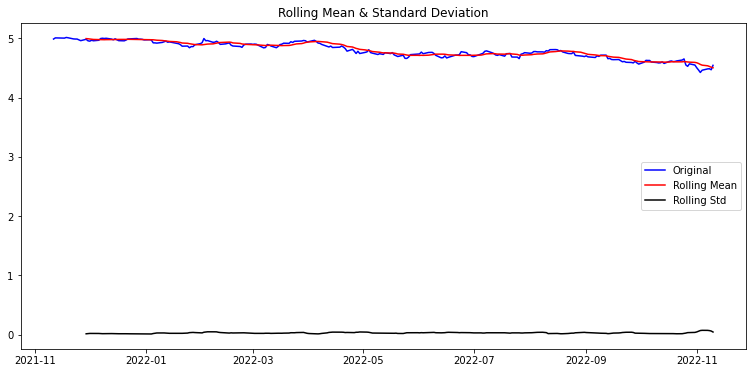

In [8]:
plot_rolling_statistics(ts_g_log, window=12)

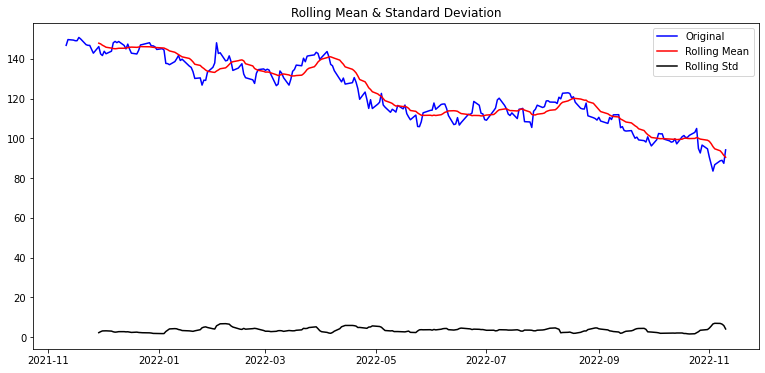

In [9]:
plot_rolling_statistics(ts_g, window=12)

로그 변환 후 그래프를 보더라도 위에서 진행했던 samsung이나 naver, kakao보다는 non stationary 하다는 것이 느껴졌다. 그래도 더 제대로 보기 위해 로그 변환 전 또한 그래프로 시각화해보았는데 눈으로 봤을 때에도 satationary하지 않다는 점이 한 번 더 느껴졌다.

### 정량적 Augmented Dicky-Fuller Test

In [10]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC') 
    
    #adfuller 메서드가 리턴한 결과를 정리하여 출력하기
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [11]:
augmented_dickey_fuller_test(ts_g_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.100659
p-value                          0.714809
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


p-value=0.71>0.05인 것을 봤을 때, 역시 구글 주식 데이터는 stationary하지 않았다.

### 시계열 분해(Time Series Decomposition)

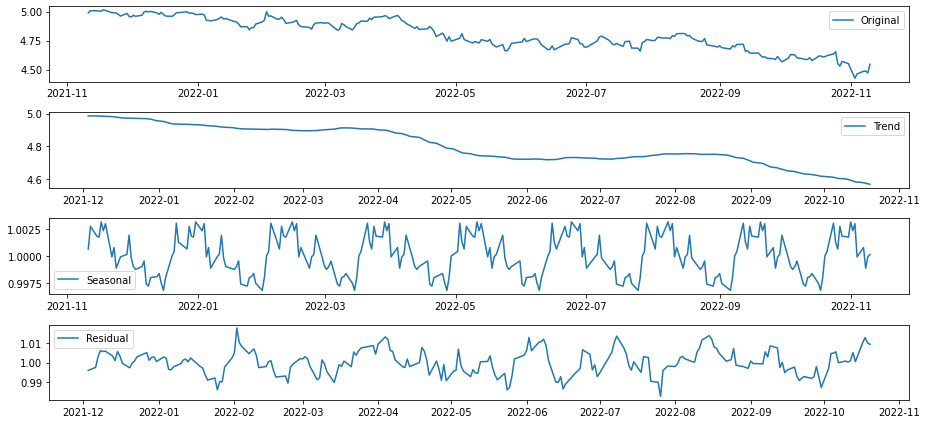

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_g_log, model='multiplicative', period = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
# residual = (로그변환한)원본 - trend - seasonal

plt.subplot(411)
plt.plot(ts_g_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()

### Residual 안정성 확인

In [13]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.562562
p-value                          0.000002
#Lags Used                       0.000000
Number of Observations Used    221.000000
Critical Value (1%)             -3.460291
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
dtype: float64


하지만 trend와 seasonal을 제거한 후에 residual이 stationary한지 ADF test를 해봤을 때, p-value=0.000002<0.05로 naver나 kakao에 비해 더 stationary하다고 할 수 있다.

## Step 4. 학습, 테스트 데이터셋 생성

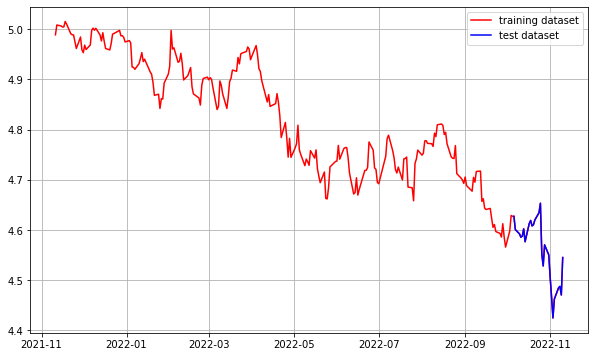

In [15]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_g_log[:int(len(ts_g_log)*0.9)], ts_g_log[int(len(ts_g_log)*0.9):]
# 학습데이터 : 테스트데이터 = 9 : 1 (학습데이터는 앞쪽부터 시작해서 9, 테스트데이터는 뒤쪽 1)
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_g_log, c='r', label='training dataset') # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## Step 5. 적정 ARIMA 모수 찾기

### ACF, PACF를 그려본 후 p,q 구하기

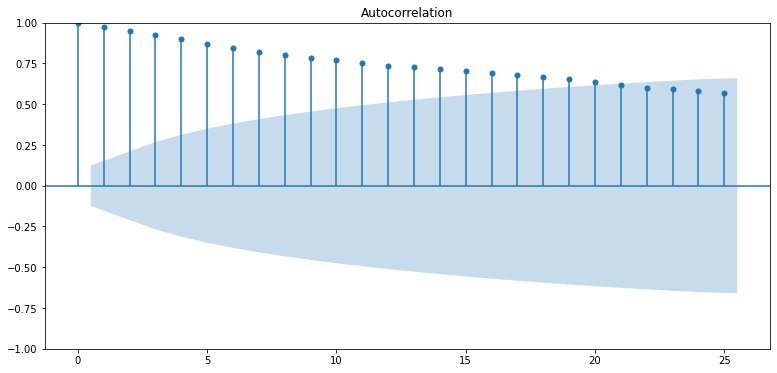

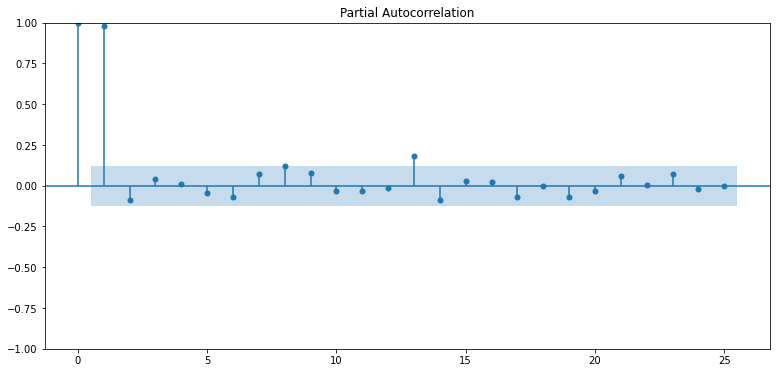

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_g_log) 
plot_pacf(ts_g_log)
plt.show()

위에서 파악한 p,q모수값 찾는 방법을 대입해보면 ACF가 완만하게 떨어지고 있으므로 non stationary하고 AR모델을 선택해서 q = 0이다. PACF는 lag 1이후에 확 떨어지는 그래프 모양을 가지고 있기 때문에 p = 1이 될 것이다.  
그리고 구글 데이터셋의 경우 PACF에서 lag 13에서도 절단되는 모습이 보이기 때문에 p=13으로도 정확도 측정을 해봐야겠다.

### 차분 안정성 확인 후 d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.642390e+01
p-value                        2.515266e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


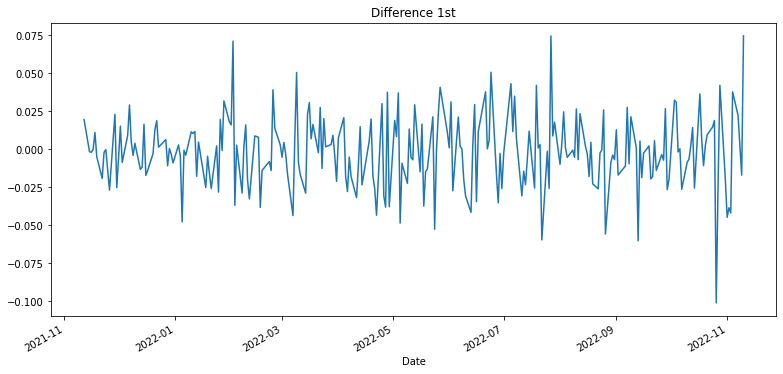

In [17]:
diff_1 = ts_g_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차 차분 이후에 p-value = 2.515266e-29 < 0.05 로 stationary하기 때문에 d = 1이 된다.

## Step 6. ARIMA 모델 훈련과 테스트

### ARIMA 모델 빌드와 훈련

In [18]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0)) # 모수 p,d,q 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 536.058
Date:                Sun, 13 Nov 2022   AIC                          -1068.116
Time:                        05:12:59   BIC                          -1061.284
Sample:                             0   HQIC                         -1065.358
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0697      0.072     -0.971      0.332      -0.211       0.071
sigma2         0.0005   4.26e-05     11.711      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.01   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


### 모델 테스트 및 플로팅

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


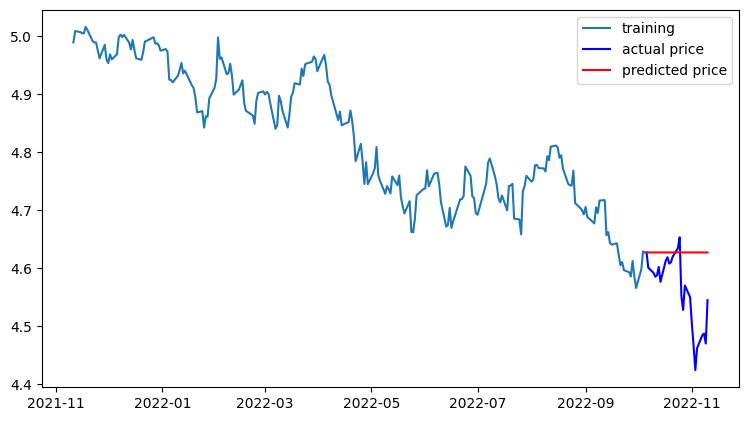

In [19]:
# Forecast : 결과가 fc에 담깁니다. 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  
fc = np.array(fc)

# pandas series로 만들기
fc_series = pd.Series(fc, index=test_data.index)

# Plot 시각화
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 최종 예측 모델 정확도 측정(MAPE)

In [20]:
# 시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차 계산 가능 
# np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)


mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  74.85690512096654
MAE:  6.663332059558537
RMSE:  8.651988506751875
MAPE: 7.34%


p=1인 상태에서 MAPE의 값은 7.34%가 나왔다.

In [24]:
model = ARIMA(train_data, order=(13, 1, 0)) # 모수 p,d,q 
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                ARIMA(13, 1, 0)   Log Likelihood                 539.043
Date:                Sun, 13 Nov 2022   AIC                          -1050.085
Time:                        05:14:42   BIC                          -1002.260
Sample:                             0   HQIC                         -1030.783
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0732      0.080     -0.919      0.358      -0.229       0.083
ar.L2         -0.0058      0.070     -0.083      0.934      -0.143       0.132
ar.L3         -0.0580      0.065     -0.899      0.3

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


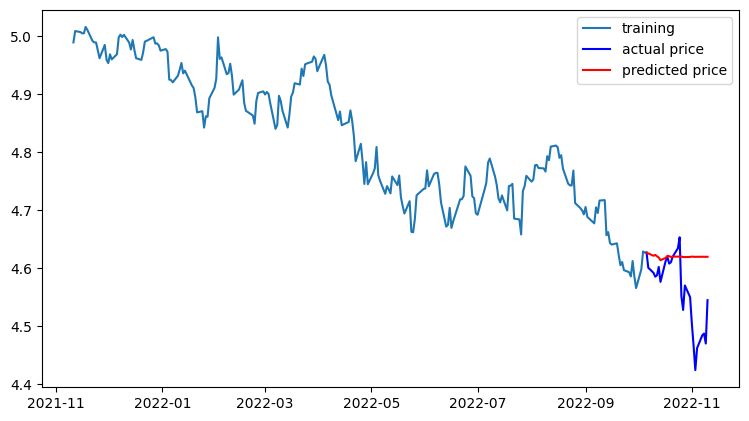

In [25]:
# Forecast : 결과가 fc에 담깁니다. 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  
fc = np.array(fc)

# pandas series로 만들기
fc_series = pd.Series(fc, index=test_data.index)

# Plot 시각화
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [26]:
# 시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차 계산 가능 
# np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)


mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  65.67570567947313
MAE:  6.066725947351671
RMSE:  8.104054891193243
MAPE: 6.70%


호기심으로 p=2일 때 MAPE값을 측정해보았다. 이때 MAPE=7.60%로 p=1일 때보다 높았다.  
p=13일 때 MAPE=6.70%로 p=1일 때 보다 0에 더 가까웠다.  
정확하게 무슨 원리로 p,q 값을 구하는 것인지 파악할 수는 없었지만 절단되는 순간의 숫자를 잘 찾아서 넣다보면 MAPE값이 더 낮아지는 거 같다.

---------------

## 회고
1. 플로팅과 adfuller 메서드 사용으로 시계열의 안정성이 확인되는 것을 시각화하고 이에 대한 이해가 되었는가?  
플로팅을 통해 원본시계열, 이동평균, 이동표준편차를 시각화해보고 adfuller 메서드를 사용해서 p-value를 얻어 해당 데이터가 stationary한지 여부를 알아보았다. 로그 변환 후 플로팅을 했을 때 숫자가 너무 작아서 stationary한지 어떤지 정확하게 알기 힘들었다. 그래서 로그 변환 전에 플로팅을 해봤는데 숫자가 크면 왜곡이 생길 가능성이 높지만 눈에는 stationary한지 어떤지 좀 더 명확하게 들어왔다.  
하지만 눈으로만 판단할 수는 없었기 때문에 ADF Test를 쉽게 할 수 있는 메서드인 adfuller를 사용하여 p-value값을 구했는데 original(원본)데이터에서는 stationary하지 않았지만 trend와 seasonl을 제거한 residual에서는 stationary한 것을 알 수 있었다.  
2. ARIMA 모델 모수선택의 근거를 제시하였는가? (p, q를 위한 ACF, PACF 사용과 d를 위한 차분 과정)  
일반적으로 AR과 MA 중 하나만 고려되는 경우가 많으므로 보통 p,q 값 중 하나는 0이 되는 경우가 많다. 그래서 보통 ARMA모델을 선택하는 경우는 많지 않은데 ACF와 PACF가 (q-p)시점 이후부터 떨어질 때 이 모델을 선택한다. 그 외에 AR모델의 경우 ACF가 완만하게 떨어지는데 PACF는 lag p 이후에 확 떨어(절단)질 경우 선택한다. 이 때에 q=0이 되고, p값이 결정된다. MA모델의 경우에는 PACF가 완만하게 떨어지는데 ACF는 lag q 이후에 절단될 때 선택한다. 이 때에 p=0이 되고, q값이 결정된다.  
삼성전자, 네이버, 카카오, 구글 모두 그래프의 모양을 보고 AR모델을 선택했는데 카카오의 경우 p값을 구할 때 절단되는 지점의 값을 넣었음에도 다른 지점의 값을 넣었을 때보다 MAPE가 높았다. 내가 잘못 이해한 것일 수도 있지만 카카오의 경우를 봤을 때 절단되는 지점에서 값을 +, - 하면서 최적의 값을 찾아나가야 할 필요도 있다는 점을 알게 되었다. 그리고 구글의 경우 절단되는 지점이 여러 곳 있다고 생각했고 그 지점의 값을 다 넣어봤는데 첫번째 절단되는 지점보다 두번째 절단되는 지점에서 p값을 넣었을 때 MAPE가 더 낮았다. 절단되는 지점이 여러 곳 보이면 그 값을 다 넣어볼 필요도 있다는 생각이 들었다.  
d는 differencing 했을 때 p-value가 0.05미만이 될 때 몇 번째 차분인지에 따라 결정된다. 보통 2차 차분까지밖에 안한다고 한다. 삼성전자, 네이버, 카카오, 구글 모두 1차 차분으로 p-value가 0.05미만이 되어 d=1인 상태에서 MAPE를 구했다.  
3. 3개 이상 종목이 MAPE 15% 미만의 정확도로 예측되었는가?  
삼성전자의 경우 오차율이 1.74%로 가장 낮았고, 그 다음으로는 네이버 3.44%, 구글 6.70%, 카카오 9.09%를 기록했다. 모두 15% 미만의 정확도로 예측되기는 하였지만 오차율을 더 줄일 수 있는 방법이 있을지 더 찾아봐야겠다.  
4. 프로젝트를 진행하면서 느낀점 : 이번 프로젝트도 LMS를 기반으로 참고를 많이 해서 완성했다. 의존도를 줄이고 싶어도 아직은 무리인 거 같다. 그래서 각 코드가 무엇을 의미하는지 정확하게 이해하는 것으로 목표를 바꿨다. 어떤 순간에 사용되는 코드인지 그 코드는 어떻게 구성되어있는지 정확하게 파악하려고 노력을 많이 한 거 같다.  
ARIMA 모델은 기본 개념을 이해하는 거 조차 쉽지 않았다. 기본 개념을 확실하게 세우고 넘어가야 하는데 특히 ARIMA모델에 있어서 trend나 seasonal의 차이라던가 정성적 그래프를 평가하는 방법이라던가 p,q값을 결정하는 방법들이 이해하기가 힘들었다. 하지만 한 번 보는 것과 두 번, 세 번, 그리고 여러 번 보는 것에는 엄청난 차이가 있다고 생각한다. 그렇기 때문에 프로젝트를 제출하고 난 뒤에도 계속 반복해서 볼 것이라고 다짐했다. 그리고 p,q값을 결정할 때 auto.arima라는 방법도 있고 그 외에도 다른 방법이 더 있다고 들었다. 더 찾아보고 공부해서 다양한 방법들을 사용해서 p,q값을 구해보는 시도도 해보고 싶다.

## reference
[결측치 보간](https://rfriend.tistory.com/264)  
[log 변환](https://leebaro.tistory.com/entry/%EB%8D%B0%EC%9D%B4%ED%84%B0-%EB%B6%84%EC%84%9D-%EC%8B%9C-%EC%8B%9D%EC%97%90-%EB%A1%9C%EA%B7%B8%EB%A5%BC-%EC%B7%A8%ED%95%98%EB%8A%94-%EC%9D%B4%EC%9C%A0)  
[adfuller](https://hongl.tistory.com/98)  
[AIC](https://student9725.tistory.com/28)  
[plt.legend()](https://codetorial.net/matplotlib/set_legend.html)  
[p,d,q 값(모수)을 구하는 방법](https://velog.io/@sjina0722/%EC%8B%9C%EA%B3%84%EC%97%B4%EB%B6%84%EC%84%9D-ARIMA-%EB%AA%A8%EB%8D%B8)  
[np.abs](https://rfriend.tistory.com/303)  
[MAPE](https://acdongpgm.tistory.com/102)